In [31]:
import tensorflow as tf
import numpy as np
import sys,time,os
from bLSTM import bLSTM
from sklearn.model_selection import train_test_split


In [198]:
def fibel_retrieve(learn_type):

    data = np.load('data/fibel.npz')
    phon_dict = np_dict_to_dict(data['phon_dict'])
    word_dict = np_dict_to_dict(data['word_dict'])

    if learn_type == 'lds':

        path = 'data/fibel_alt_targets.npy'
        print("Loading alternative targets ...")
        alt_targs_raw = np.load(path)


        alt_targs = np.array([np.array(d,dtype=np.int8) for d in alt_targs_raw])
        print("Alternative targets successfully loaded.")

        return ( (data['phons'], data['words']) , (phon_dict, word_dict), alt_targs )
    else:
        return ( (data['phons'], data['words']) , (phon_dict, word_dict))

def np_dict_to_dict(np_dict):
    """
    Converts a dictionary saved via np.save (as structured np array) into an object of type dict

    Parameters:
    --------------
    NP_DICT        : {np.array} structured np.array with dict keys and items

    Returns:
    --------------
    DICT            : {dict} converted NP_DICT

    """

    return {key:np_dict.item().get(key) for key in np_dict.item()}

def num_to_str(inputs,logits,labels,alt_targs,dict_in,dict_out,mode='normal'):
    """
    Method receives the numerical arrays and prints the strings

    If mode = normal, then alt_targs should be set to [], if it is 'lds' the alternative targets are also printed
    """

    fullPred = logits.argmax(-1) # Prediction string with padding

    
    #Padded target string
    fullTarg = np.copy(labels) 
    # Set pads to 0 - as preparation for edit_distance

    out_str = []
    inp_str = []
    label_str = []
    #print(inputs.shape,fullPred.shape,labels.shape,alt_targs.shape)
    #print(dict_in)
    #print(dict_out)
    #print(inputs[0:5],fullPred[:5],labels[:5])
    for k in range(len(fullPred)):
        out_str.append(''.join([dict_out[l] if dict_out[l] != '<PAD>' and  dict_out[l] != '<GO>' else '' for l in fullPred[k]]))
        inp_str.append(''.join([dict_in[l] if dict_in[l] != '<PAD>' and  dict_in[l] != '<GO>' else '' for l in inputs[k]]))
        label_str.append(''.join([dict_out[l] if dict_out[l] != '<PAD>' and  dict_out[l] != '<GO>' else '' for l in labels[k]]))

        print("The input " + inp_str[-1].upper() + " was written as " + out_str[-1].upper() + " with the target as " + label_str[-1].upper())

        if mode == 'lds':
            alt_targ_str = []

            z = np.argwhere(alt_targs[k]==0) # indices of zeros (alt_targs where padded to have equally sized array)
            # position 0,1 is the first row that contains zeros (i.e. not an alternative writing anymore)
            for l in range(z[0,1]):
                alt_targ_str.append(''.join([dict_out[m] if dict_out[m] != '<PAD>' and  dict_out[m] != '<GO>' else '' for m in alt_targs[k,:,l] ]))
            print("The alternatives were ", alt_targ_str)

            
def set_model_params(inputs, targets, dict_char2num_x, dict_char2num_y):
    """
    This method can receive data from any dataset (inputs, targets) and the corresponding dictionaries.
    It returns the hyperparameters for the model, i.e. input and output sequence length as well as input and output dictionary size.
    """

    # Error handling. If the dicts are not objects of type dict but np.arrays (dicts saved via np.save), convert them back.
    if isinstance(dict_char2num_x, np.ndarray):
        dict_char2num_x = np_dict_to_dict(dict_char2num_x)
    if isinstance(dict_char2num_y, np.ndarray):
        dict_char2num_y = np_dict_to_dict(dict_char2num_y)


    dict_num2char_x = dict(zip(dict_char2num_x.values(), dict_char2num_x.keys()))
    dict_num2char_y = dict(zip(dict_char2num_y.values(), dict_char2num_y.keys()))
    x_dict_size = len(dict_char2num_x)
    num_classes = len(dict_char2num_y) # (y_dict_size) Cardinality of output dictionary
    x_seq_length = len(inputs[0]) - 1 
    y_seq_length = len(targets[0]) - 1 # Because of the <GO> as response onset

    return x_dict_size, num_classes, x_seq_length, y_seq_length, dict_num2char_x, dict_num2char_y



In [197]:
tf.InteractiveSession()

max_alt_wr = 2
bs = 3
seq_len = 4

targ = tf.constant([[3,7,12,4],[18,18,2,2],[18,2,2,2]])

wr = tf.constant([[3,7,12,1],[18,18,2,9],[18,7,2,2]],dtype=tf.int8)
print('BEF',wr.get_shape())
wr = tf.expand_dims(tf.ones([max_alt_wr,1],dtype=tf.int8),1) * wr
print(wr.get_shape())
wr = tf.transpose(wr,[1,2,0])


alt_wr = tf.constant([[[4,7,12,1],[3,7,12,1]],[[1,2,3,4],[1,2,3,3]],
                      [[18,7,2,2],[18,9,2,2]]],dtype=tf.int8)
alt_wr = tf.transpose(alt_wr,[0,2,1])


equal_raw = tf.equal(wr,alt_wr)
equal = tf.reduce_all(equal_raw,1)
equal_ind = tf.where(equal)


a = equal_ind[:,0]
print(type(targ),type(alt_wr),type(equal_ind))
print(targ.eval(),"That was current state")

# This is just the creation of the node new_targts.
new_targets = tf.py_func(update_tensor,[targ, alt_wr, equal_ind], tf.int8)
# This actually executes the new function
print(new_targets.eval())




BEF (3, 4)
(2, 3, 4)
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
[[ 3  7 12  4]
 [18 18  2  2]
 [18  2  2  2]] That was current state
(3, 4)
(3, 4, 2)
(2, 2)
YAY!
YAY!
DONE
[[ 3  7 12  1]
 [18 18  2  2]
 [18  7  2  2]]


In [160]:
a = np.array([2,3,4])

print(np.where(a==2))


(array([0]),)


In [122]:
sess = tf.InteractiveSession()

a = tf.constant([2, 5, -4, 0])
aa = tf.Variable(a)
print(type(aa))
sess.run(tf.initialize_all_variables())
b = tf.scatter_update(aa, [1], [9])
print(b.eval())

<class 'tensorflow.python.ops.variables.Variable'>
[ 2  9 -4  0]


In [199]:
((inputs, targets) , (dict_char2num_x, dict_char2num_y), alt_targets) = fibel_retrieve('lds')
x_dict_size, num_classes, x_seq_length, y_seq_length, dict_num2char_x, dict_num2char_y = set_model_params(inputs, targets, dict_char2num_x, dict_char2num_y)



indices = range(len(inputs))
X_train, X_test,Y_train, Y_test, Y_alt_train_l, Y_alt_test_l, ind_train, ind_test = train_test_split(inputs, targets, alt_targets,indices,test_size=0.1, random_state=42)




#logp = np.reshape(np.arange(174*22*30),[174,22,30])
max_len = max([len(l) for l in Y_alt_train_l])
inp_seq_len = len(Y_alt_train_l[1][0])
Y_alt_train = np.zeros([len(Y_alt_train_l), inp_seq_len, max_len], dtype=np.int8)
for word_ind in range(len(Y_alt_train_l)):
    for write_ind in range(len(Y_alt_train_l[word_ind])):
        Y_alt_train[word_ind,:,write_ind] = np.array(Y_alt_train_l[word_ind][write_ind],dtype=np.int8)
#a=num_to_str(X_train,logp,Y_train,Y_alt_train,dict_num2char_x,dict_num2char_y,'lds')
print(X_train.shape, Y_train.shape, Y_alt_train.shape)



Loading alternative targets ...
Alternative targets successfully loaded.
(156, 12) (156, 22) (156, 28, 810)


In [54]:
dict_num2char_x

{1: 'U',
 2: 'l',
 3: 'z',
 4: 'e',
 5: 'p',
 6: '|',
 7: 'x',
 8: 'o',
 9: 'i',
 10: 'a',
 11: 'N',
 12: 'E',
 13: 'u',
 14: 'I',
 15: 'd',
 16: 'b',
 17: 't',
 18: 'h',
 19: '#',
 20: 'm',
 21: 'j',
 22: '@',
 23: ' ',
 24: 'r',
 25: 'k',
 26: '/',
 27: '+',
 28: 'S',
 29: 's',
 30: 'n',
 31: ':',
 32: 'O',
 33: 'y',
 34: 'g',
 35: 'f',
 36: 'v',
 37: 'Y',
 38: '<GO>',
 39: '<PAD>'}

In [172]:
# Understand how to initialize 2 Tensorflow models,
# train them in one session, and save them independently


class model(object):
    
    def __init__(self,size):
        
        self.inp = tf.placeholder(tf.float32,(size,2),'inp')
        self.mat = tf.placeholder(tf.float32,(2,5),'mat')
        
        
        
    def foo(self):
        self.out = tf.matmul(self.inp,self.mat)
        
    
    

In [184]:
small = model(3)
small.foo()
large = model(10)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(max_to_keep=4)

    
    b = sess.run(small.out, feed_dict={small.inp:np.random.random((3,2)),
                                      small.mat:np.random.random((2,5))})
    print(b)
    
    saver.save(sess, save_path + '/Model', global_step=epoch, write_meta_graph=False)

ValueError: No variables to save

In [222]:
def np_dict_to_dict(np_dict):
    """
    Converts a dictionary saved via np.save (as structured np array) into an object of type dict

    Parameters:
    --------------
    NP_DICT        : {np.array} structured np.array with dict keys and items

    Returns:
    --------------
    DICT            : {dict} converted NP_DICT

    """

    return {key:np_dict.item().get(key) for key in np_dict.item()}



def extract_celex(path):
    """
    Reads in data from the CELEX corpus
    
    Parameters:
    -----------
    PATH        {str} the path to the desired celex file, i.e. gpl.cd 
                    (contains orthography and phonology)

    Returns:
    -----------
    2 Tuples, each with 2 variables. 
        First tuple:
    W           {np.array} of words (length 51728) for gpl.cd
    P           {np.array} of phoneme sequences (length 51728) for gpl.cd
        Second tuple:
    WORD_DICT   {dict} allowing to map the numerical array W back to strings
    PHON_DICT   {dict} doing the same for the phonetical arrays P

    
    Call via:
    path = "/Users/jannisborn/Desktop/LDS_Data/celex2/german/gpl/gpl.cd"
    ((w,p) , (word_dict, phon_dict)) = extract_celex(path)
    
    """
    
    
    with open(path, 'r') as file:

        raw_data = file.read().splitlines()
        words = []
        phons = []
        m = 0
        for ind,raw_line in enumerate(raw_data):
            
            line = raw_line.split("\\")

            if line[-2]: # Use only words that HAVE a SAMPA transcript (reduces from 51k to 37345)

            # exclude foreign words that have the 'æ' tone (SAMPA '{' ) like in PoINte   - 18 words
            # exclude foreign words that have the 'ɑ' tone (SAMPA 'A' ) like in NuANce   - 28 words
            # exclude foreign words that have a nasal vowel (SAMPA '~' ) like in Jargon  - 22 words
                if not 'A' in line[-2] and not '{' in line[-2] and not '~' in line[-2]: 

                    if not ('tS' in line[-2] and not 'tsch' in line[1]): # exclude 9 foreign words like 'Image', 'Match', 'Punch', 'Sketch'

                        if len(line[1]) < 15 and len(line[-2]) < 15 : # exclude extra long words (reduces to 34376)
                            
                            if len(line[-2]) > m:
                                m = len(line[-2])
                                print(line[1],line[-2])
                                

                            words.append(line[1].lower()) # All words are lowercase only
                            phons.append(line[-2]) # Using SAMPA notation

    return words,phons



def str_to_num_dataset(X,Y):
    """
    This method receives 2 lists of strings (input X and output Y) and converts it to padded, numerical arrays.
    It returns the numerical dataset as well as the dictionaries to retrieve the strings.
    """

    # 1. Define dictionaries 
    # Dictionary assignining a unique integer to each input character
    try:
        u_characters = set(' '.join(X)) 
    except TypeError:
        # Exception for TIMIT dataset (one phoneme is repr. by seq. of chars)
        print("TypeError occurred.")
        u_characters = set([quant for seq in X for quant in seq])

    char2numX = dict(zip(u_characters, range(1,len(u_characters)+1)))

    # Dictionary assignining a unique integer to each phoneme
    try:
        v_characters = set(' '.join(Y)) 
    except TypeError:
        print("TypeError occurred.")
        v_characters = set([quant for seq in Y for quant in seq])
    char2numY = dict(zip(v_characters, range(1,len(v_characters)+1))) # Using 0 causes trouble for tf.edit_distance
    
    # 2. Padding
    # Pad inputs
    char2numX['<GO>'] = len(char2numX) + 1
    char2numX['<PAD>'] = len(char2numX) + 1
    mx_l_X = max([len(word) for word in X]) # longest input sequence
    # Padd all X for the final form for the LSTM
    x = [[char2numX['<GO>']] + [char2numX['<PAD>']]*(mx_l_X - len(word)) +[char2numX[char] for char in word] for word in X]
    x = np.array(x) 

    # Pad targets
    char2numY['<GO>'] = len(char2numY) + 1 # Define number denoting the response onset
    char2numY['<PAD>'] = len(char2numY) + 1 
    mx_l_Y = max([len(phon_seq) for phon_seq in Y]) # longest output sequence

    y = [[char2numY['<GO>']] + [char2numY['<PAD>']]*(mx_l_Y - len(ph_sq)) + [char2numY[phon] for phon in ph_sq] for ph_sq in Y]
    y = np.array(y)

    return ((x,y) , (char2numX,char2numY))




In [214]:
data = np.load('data/celex.npz')
phon_dict = np_dict_to_dict(data['phon_dict'])
word_dict = np_dict_to_dict(data['word_dict'])


datao = np.load('data/celex_old.npz')
phon_dicto = np_dict_to_dict(datao['phon_dict'])
word_dicto = np_dict_to_dict(datao['word_dict'])

################## DATA ANALYSIS #####################

In [222]:
normal_data = np.load('/Users/jannisborn/Dropbox/GitHub/LSTM/Models/fibel/normal_run_1/metrics.npz')


trainPerf = normal_data['trainPerf']
testPerf = normal_data['testPerf']
lds_ratio = normal_data['lds_ratio']
corr_ratio = normal_data['corr_ratio']
lds_loss = normal_data['lds_loss']
reg_loss = normal_data['reg_loss']



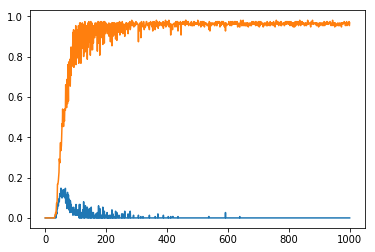

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = np.arange(1001)

plt.plot(epochs,lds_ratio)
plt.plot(epochs, corr_ratio)
plt.show()